<a href="https://www.kaggle.com/code/magedmahmoud/mastering-sentiment-analysis?scriptVersionId=120075589" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Frame the problem and look at the big picture:
In this notebook we use various techniques and recent methods in text classification from rule based sentiment analysis to Machine learning based Sentiment Analysis.

**This Notebook will give step by step approach to NLP Sentiment Analysis from basic models to deep learning models** 

### What is Sentiment Analysis?
Sentiment Analysis is a NLP technique used to interpret the emotions, comments and reviews (Positive, Negative or Natural) behind text data.
### Applications of Sentiment Analysis:
* Social Media Analysis
* Public Sentiment about products
* Content Moderation
* Stock Market Analysis


**Some Code here is imported from **SOHAIL notebook****

# Get The Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-sentiment-analysis/data.csv
/kaggle/input/fast-text-embeddings-without-subwords/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec
/kaggle/input/fast-text-embeddings-without-subwords/crawl-300d-2M.vec/crawl-300d-2M.vec
/kaggle/input/glove6b50dtxt/glove.6B.50d.txt
/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin.gz
/kaggle/input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin
/kaggle/input/glove2word2vec/glove_w2v.txt


## Import Files and Libraries

In [2]:
%%capture
!pip install tensorflow_text
!pip install transformers

In [3]:
# nltk imports
from nltk.tokenize import word_tokenize  # tokenize the text == the text is splitted into words in list
from nltk.corpus import stopwords  # this contain common stop words that has no effect in analysis
from nltk.stem import WordNetLemmatizer  # Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item

# sklearn imports
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # bags of words and TF IDF
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix, make_scorer  # classification Metrics
from sklearn.naive_bayes import MultinomialNB  # Multiclassification
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import StratifiedKFold  # For stratified splitting (helpful in imbalanced data)
from sklearn.preprocessing import LabelBinarizer  # for Categorical features
from sklearn.model_selection import GridSearchCV  # for tuning parameters
from sklearn.model_selection import train_test_split  # splitting dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model

# gensim imports
from gensim.models import KeyedVectors  # to save and load vectors
import string
import re
import pandas as pd
import numpy as np
import xgboost as xgb
import catboost as cbt

# tensorflow and keras
import keras
from keras import backend as K
from tensorflow.keras.layers import Embedding
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence, text
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.utils import np_utils
from keras.callbacks import EarlyStopping , ReduceLROnPlateau
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Hugging Face Transformers
from transformers import (pipeline , BertTokenizer,
                          TFBertForSequenceClassification,
                          InputExample, InputFeatures , 
                         AutoTokenizer, TFAutoModelForSequenceClassification,
                         TFRobertaModel, TFGPT2Model, RobertaTokenizer, GPT2Tokenizer)


In [4]:
df = pd.read_csv('/kaggle/input/financial-sentiment-analysis/data.csv')

df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [5]:
df.shape

(5842, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [7]:
unique_sentiments = df.Sentiment.unique()
unique_sentiments

array(['positive', 'negative', 'neutral'], dtype=object)

<AxesSubplot:>

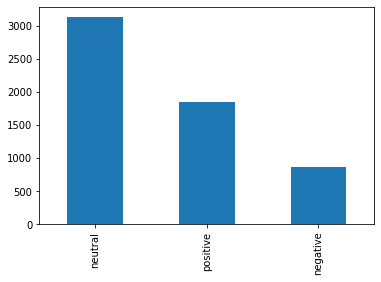

In [8]:
df.Sentiment.value_counts().plot.bar()

In [9]:
# mapping to the sentiment column 

dicto = {'positive': 1, 'neutral': 0 , 'negative': -1}

df.Sentiment = df.Sentiment.map(dicto)

In [10]:

def classical_model(df, bow=False, TFIDF=False, Ngram=False,
                    model=linear_model.LogisticRegression(solver='liblinear')):
    '''
    Automates classical models to train and evaluate Sentiment Analysis Models.

    Args:
    df : pandas DataFrame
        DataFrame with columns Sentence and Sentiment
    bow : bool
        Flag for using bag of words (binary, count, or frequency)
    TFIDF : bool
        Flag for using Tfidf vectorization
    Ngram : tuple
        Shape of Ngram range (e.g. (1,2) for bigrams)
    model : scikit-learn estimator
        Model to be used for training

    Returns:
    None
    '''

    df['kfold'] = -1 # Add a column to split data later
    df = df.sample(frac=1).reset_index(drop=True) # Shuffle data and reset index

    # Initiate kfold class from model_selection module
    np.random.seed(0)
    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits)

    for f, (train, val) in enumerate(kf.split(X=df, y=df.Sentiment)):
        df.loc[val, 'kfold'] = f # Assign each row to its validation set number

    if bow:
        count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None)
    elif TFIDF:
        count_vec = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
    elif Ngram:
        count_vec = CountVectorizer(tokenizer=word_tokenize, token_pattern=None, ngram_range=Ngram)

    for fold_ in range(n_splits):
        train_df = df[df.kfold != fold_].reset_index(drop=True)
        test_df = df[df.kfold == fold_].reset_index(drop=True)
        count_vec.fit(train_df.Sentence)
        xtrain = count_vec.transform(train_df.Sentence)
        xtest = count_vec.transform(test_df.Sentence)
        model.fit(xtrain, train_df.Sentiment)
        preds = model.predict(xtest)
        accuracy_precision = precision_score(test_df.Sentiment, preds, average='macro')
        accuracy_recall = recall_score(test_df.Sentiment, preds, average='macro')
        print('precision score:', accuracy_precision)
        print('recall score:', accuracy_recall)
        print("========================================================")

    print(classification_report(test_df.Sentiment, preds))

# Model-1 
### Logistic + BOW

In [ ]:
#Baseline model let's start with a logistic regression model since it is the fastest for high dimensional sparse data

classical_model(df, bow =True,model=linear_model.LogisticRegression(solver = 'liblinear'))

We can see that labels **1,0 have more than 70 percent** score but label **-1 score is pretty low**, hence we can conclude that we need to go on modelling untill these scores get better.

# Model 2 NaiveBayes + BOW

In [13]:
# Lets try with NaiveBayes model 

classical_model(df,bow = True,model = MultinomialNB()) # multiclassification

precision score: 0.6228029247397492
recall score: 0.5869766066681366
precision score: 0.6584857466391166
recall score: 0.6133894079299903
precision score: 0.610298418490932
recall score: 0.5702695674350329
precision score: 0.6173100148643628
recall score: 0.5800834231958386
precision score: 0.6334566048227578
recall score: 0.5991385248090798
              precision    recall  f1-score   support

          -1       0.43      0.29      0.35       172
           0       0.74      0.84      0.78       626
           1       0.73      0.66      0.70       370

    accuracy                           0.70      1168
   macro avg       0.63      0.60      0.61      1168
weighted avg       0.69      0.70      0.69      1168



It is evident that the for **label -1 the metrics values little improved** so this model will be the new baseline model for this problem.

# Model-3 Naive Bayes with TFIDF

In [14]:
# Now lets try with TF-IDF vectorizer instead of bag of words to MultinomialNB().

classical_model(df, model= MultinomialNB(),TFIDF=True)

precision score: 0.8032709303221403
recall score: 0.4716788874026719
precision score: 0.7965176893969463
recall score: 0.46977391388054385
precision score: 0.7755521472392638
recall score: 0.44167046532378285
precision score: 0.6706332757628094
recall score: 0.4582149725325296
precision score: 0.6951144094001237
recall score: 0.45724589661360593
              precision    recall  f1-score   support

          -1       0.75      0.02      0.03       172
           0       0.64      0.98      0.77       626
           1       0.70      0.37      0.48       370

    accuracy                           0.65      1168
   macro avg       0.70      0.46      0.43      1168
weighted avg       0.67      0.65      0.57      1168



also, the **label -1 metrics recall score is unsatisfied**  

# Model-4 Naive Bayes with Ngrams

In [15]:
# Now to the baseline bag of word Naivebayes model lets apply Ngrams  and compare the results.

# Lets try with NaiveBayes model 

classical_model(df, model = MultinomialNB(), Ngram=(1,2))

precision score: 0.571222426085165
recall score: 0.5456817640637264
precision score: 0.5705919969119083
recall score: 0.5462114750418011
precision score: 0.5870069211261302
recall score: 0.5530476943992064
precision score: 0.5673112087008567
recall score: 0.5451441113451664
precision score: 0.5778658016420254
recall score: 0.5594099263093988
              precision    recall  f1-score   support

          -1       0.27      0.16      0.20       172
           0       0.72      0.84      0.78       626
           1       0.74      0.68      0.71       370

    accuracy                           0.69      1168
   macro avg       0.58      0.56      0.56      1168
weighted avg       0.66      0.69      0.67      1168



So the **ngrams has even decreased the metrics** value.Hence it is evident that the baseline model is still the best one till now

# Text processing

I will **not remove all stopwords** in this because it might change the context of the sentence.

e.g **"He is not a good person"** will be changed into **" 'He' , 'good', 'person'"** which is the complete opposite of the sentence.

In [ ]:
# Now lets do some cleaning on the text data and apply it to baseline model and compare the accuracies.
stop_words = [i for i in stopwords.words('english') if "n't" not in i and i not in ('not','no')]

def process_text(text):
    
    text = word_tokenize(text) # tokenize words in text
    text = [re.sub('[^A-Za-z]+', '', word) for word in text] # this line substitutes any white space before the word by removing the space
    text = [word.lower() for word in text if word.isalpha()] # lower each word in text
    text = [word for word in text if word not in stop_words]
    text = [WordNetLemmatizer().lemmatize(word) for word in text] # lemmatization of words, so when see persons an person, both are dealt as one word person
    text = ' '.join(text) # join words into text again
    return text

In [ ]:
text = 'He is not a good person'
token_text = word_tokenize(text)
[ word for word in token_text if word not in stop_words]

In [ ]:
df.Sentence = df.Sentence.apply(process_text) # this line applies process_text function to Sentence in dataset
df.Sentence

# Model 5 cleaned text Naive Bayes + BOW  

In [19]:
#Now lets try this on our baseline MultinomialNB bagofwords model

classical_model(df, model = MultinomialNB(),bow = True)

precision score: 0.6421374863757188
recall score: 0.6138530969600732
precision score: 0.6007498465847156
recall score: 0.5834384076974782
precision score: 0.6196447230929989
recall score: 0.5952158340077204
precision score: 0.6034499172426201
recall score: 0.5944203583924218
precision score: 0.610425472494438
recall score: 0.5994605572211634
              precision    recall  f1-score   support

          -1       0.36      0.33      0.34       172
           0       0.75      0.80      0.77       626
           1       0.72      0.68      0.70       370

    accuracy                           0.69      1168
   macro avg       0.61      0.60      0.60      1168
weighted avg       0.68      0.69      0.69      1168



after some text cleaning **we beat our baseline model by small margin** hence the above model will be our new baseline model.

Now lets go into **word embeddings** 

In the above models each word token is converted into integer tokens by (BOW and TFIDF) now lets convert these **integer tokens into vectors.**

# Model 6 Fastext vector with Naive Bayes Baseline 

In [20]:
# In this model we will use fastText vectors and also convert each word vector in sentence vector.
# The code is taken from https://fasttext.cc/docs/en/english-vectors.html, this code splits each vector by 
# space and return for more info go through the above link.

def sentence_to_vec(sentence, embedding_dict, tokenizer):
    # This function converts a sentence to a vector of word vectors
    words = tokenizer(sentence)
    embedding_list = []
    for word in words:
        if word in embedding_dict:
            embedding_list.append(embedding_dict[word])
    if len(embedding_list) == 0:
        # if no vectors are found, return zeros
        return np.zeros(300)
    embedding_list = np.array(embedding_list)
    vector = embedding_list.sum(axis=0) / len(embedding_list)
    return vector


df = df.sample(frac=1).reset_index(drop=True)
y = df['Sentiment'].values
df.drop('kfold', axis=1, inplace=True)
kf = StratifiedKFold(n_splits=5)

# Load embeddings into memory
print("Loading embeddings")
embeddings = KeyedVectors.load_word2vec_format('/kaggle/input/fast-text-embeddings-without-subwords/crawl-300d-2M.vec/crawl-300d-2M.vec')

# Create sentence embeddings
print("Creating sentence vectors")
vectors = []
for sentence in df['Sentence'].values:
    vectors.append(sentence_to_vec(sentence=sentence, embedding_dict=embeddings, tokenizer=word_tokenize))
vectors = np.array(vectors)

for fold_, (train_, valid_) in enumerate(kf.split(X=df, y=y)):
    print("Fold: ", fold_)
    x_train = vectors[train_, :]
    y_train = y[train_]
    x_test = vectors[valid_, :]
    y_test = y[valid_]
    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    model = MultinomialNB()
    model.fit(x_train_scaled, y_train)
    y_pred = model.predict(x_test_scaled)
    pres_score = precision_score(y_test, y_pred, average='macro')
    rec_score = recall_score(y_test, y_pred, average='macro')
    print('Precision and recall scores:', pres_score, rec_score)
    print("======================================================")

print(classification_report(y_test, y_pred, labels=[1, -1, 0]))

Loading embeddings
Creating sentence vectors
Fold:  0
Precision and recall scores: 0.40322424944492713 0.34358252312921067
Fold:  1
Precision and recall scores: 0.3396240744256693 0.3394891623537111
Fold:  2
Precision and recall scores: 0.3666049923718635 0.3441844400310854
Fold:  3
Precision and recall scores: 0.3590900214801797 0.3440203782056817
Fold:  4
Precision and recall scores: 0.3642276422764228 0.3416457991537864
              precision    recall  f1-score   support

           1       0.55      0.03      0.06       370
          -1       0.00      0.00      0.00       172
           0       0.54      1.00      0.70       626

    accuracy                           0.54      1168
   macro avg       0.36      0.34      0.25      1168
weighted avg       0.47      0.54      0.39      1168



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Pr

**Whoa! It is our worst performing model so far! What should we do now? Should we ask muppets to save us? No! we will keep on trying with other models and methods.Thats what data scientists do!**

# Model 7 - Glove vectors with Baseline model

In [21]:


class Word2VecVectorizer:
    
    
    def __init__(self, word_vectors):
        print("Loading in word vectors...")
        self.word_vectors = word_vectors
        print("Finished loading in word vectors")

    def fit(self, data):
        pass

    def transform(self, data):
        # Determine the dimensionality of vectors
        v = self.word_vectors.get_vector('king')
        self.D = v.shape[0]

        X = np.zeros((len(data), self.D))
        n = 0
        empty_count = 0

        for sentence in data:
            tokens = sentence.split()
            vecs = []
            m = 0

            for word in tokens:
                try:
                    vec = self.word_vectors.get_vector(word)
                    vecs.append(vec)
                    m += 1
                except KeyError:
                    pass

            if len(vecs) > 0:
                vecs = np.array(vecs)
                X[n] = vecs.mean(axis=0)
            else:
                empty_count += 1

            n += 1

        print("Number of samples with no words found: %s / %s" % (empty_count, len(data)))
        return X

    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [22]:
word2vec_output_file = '/kaggle/input/glove2word2vec/glove_w2v.txt'
word_vectors = KeyedVectors.load_word2vec_format(word2vec_output_file, binary = False)
Xtrain,Xtest,ytrain,ytest = train_test_split(df.Sentence, df.Sentiment, test_size = 0.2, 
                                             random_state = 42,stratify =df.Sentiment )

In [23]:
#we create a Vectorizer object that will help us to transform our reviews to vectors, a numerical representation. 
#Then we can use those vectors to feed our classifier.

vectorizer = Word2VecVectorizer(word_vectors)

X_train = vectorizer.fit_transform(Xtrain)
y_train = ytrain

X_test = vectorizer.transform(Xtest)
y_test = ytest

Loading in word vectors...
Finished loading in word vectors
Number of samples with no words found: 0 / 4673
Number of samples with no words found: 0 / 1169


In [24]:
# Define the parameters to tune
parameters = {
    'C': [0.5, 1.0, 3],
    'gamma': [1, 'auto', 'scale'],
    'kernel': ['rbf','linear']
}

model = GridSearchCV(SVC(), parameters, cv=5, n_jobs=-1,verbose=1)

model.fit(X_train,y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test,y_pred))
print(model.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  4.0min finished


              precision    recall  f1-score   support

          -1       0.60      0.20      0.30       172
           0       0.72      0.92      0.80       626
           1       0.75      0.63      0.69       371

    accuracy                           0.72      1169
   macro avg       0.69      0.58      0.60      1169
weighted avg       0.71      0.72      0.69      1169

{'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}


**Model 7 is our best performing model,then model 5, lets do some hyperparameter tuning before we move on to deep learning models**

# Model # Hyperparameter tuning best models

In [25]:
# model 5 Tuning
def scoring(y_train,y_pred):
    return f1_score(y_train,y_pred,average='macro')

count_vec = CountVectorizer(tokenizer = word_tokenize, token_pattern = None)

X_train = count_vec.fit_transform(df.Sentence)

parameters = {'alpha': [0.001,0.01,0.1,0.2,0.3,0.5,0.7,1,1.5,1.6,1.8,10,100]}

model = MultinomialNB()

grid_search = GridSearchCV(model , parameters, cv=5, scoring = make_scorer(scoring), n_jobs = -1, verbose= 1)

grid_result = grid_search.fit(X_train, df.Sentiment)

print('Best params: ', grid_result.best_params_)
print('Best score: ', grid_result.best_score_)



Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Best params:  {'alpha': 0.7}
Best score:  0.6076783924643652


[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:    0.4s finished


In [26]:
# Lets also check svm hyperparameters using pipelines

df = df.sample(frac=1,random_state=42).reset_index(drop=True)



count_vec = CountVectorizer(tokenizer = word_tokenize, token_pattern = None)

X_train = count_vec.fit_transform(df.Sentence)

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf','linear']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 1, cv=5, scoring = make_scorer(scoring), n_jobs = -1)
 
# fitting the model for grid search
grid.fit(X_train, df.Sentiment)

print('Best params: ', grid.best_params_)
print('Best score: ', grid.best_score_)



Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:  7.1min finished


Best params:  {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
Best score:  0.5597634166585358


**The model has performed worser than the previous above model, we can also create different pipelines of different machine learning models and compare them with both BOW and tfidf models**

**More models including deep learning models are yet to come**


# Deep Learning Models:

# Model- 8 LSTM using glove word2vec

In [27]:
# loading pretrained google news word2vec embedding 300D
word2vec_pretrained = KeyedVectors.load_word2vec_format("../input/googles-trained-word2vec-model-in-python/GoogleNews-vectors-negative300.bin",binary=True)
word2vec_pretrained_dict = dict(zip(word2vec_pretrained.key_to_index.keys(),
                                    word2vec_pretrained.vectors))

In [28]:
list(word2vec_pretrained_dict.values())[0].shape

(300,)

In [17]:

df['Sentence'] = df['Sentence'].apply(process_text)

X_train,X_test,y_train,y_test = train_test_split(df.Sentence, df.Sentiment, test_size = 0.2,
                                                 random_state = 42, stratify= df.Sentiment, shuffle = True)

In [18]:
y_train_enc = np_utils.to_categorical(y_train, 3)
y_test_enc = np_utils.to_categorical(y_test, 3)

In [19]:
token = tf.keras.preprocessing.text.Tokenizer(num_words=None)

token.fit_on_texts(list(X_train) + list(X_test)) # fits tokens on texts
xtrain_seq = token.texts_to_sequences(X_train) # text to sequences converts the sentence words to number sequences
xtest_seq = token.texts_to_sequences(X_test)

#zero pad sequences
xtrain_pad = pad_sequences(xtrain_seq,padding='post') # zero padding all sentences to have the same shape as the largest one
xtest_pad = pad_sequences(xtest_seq,padding='post')

word_index = token.word_index # returns the word index that have been tokenized


In [32]:
#create embedding matrix for words that we have in dataset

embedding_matrix = np.zeros((len(word_index)+1, 300))
for word,i in word_index.items():
    embedding_vector = word2vec_pretrained_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

In [22]:
# Build Custom Metrics (F1-Score)


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m_():
    def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))
    return f1_m


In [35]:
# A simple LSTM with two dense layers

model = Sequential()
model.add(Embedding(len(word_index)+1,300,weights=[embedding_matrix], trainable = False))

model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3))

model.add(Dense(1024 , activation = 'relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation = 'relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = [f1_m_()])

In [36]:
model.fit(xtrain_pad, y=y_train_enc, batch_size = 512, epochs =10, verbose=1, validation_data = (xtest_pad, y_test_enc))

Epoch 1/10
10/10 [==============================] - 22s 2s/step - loss: 1.0296 - f1_m: 0.1921 - val_loss: 0.9718 - val_f1_m: 0.5062
Epoch 2/10
10/10 [==============================] - 16s 2s/step - loss: 0.9546 - f1_m: 0.4834 - val_loss: 0.9960 - val_f1_m: 0.4698
Epoch 3/10
10/10 [==============================] - 18s 2s/step - loss: 0.9157 - f1_m: 0.4882 - val_loss: 0.8874 - val_f1_m: 0.5226
Epoch 4/10
10/10 [==============================] - 17s 2s/step - loss: 0.8864 - f1_m: 0.5030 - val_loss: 0.8715 - val_f1_m: 0.5020
Epoch 5/10
10/10 [==============================] - 18s 2s/step - loss: 0.8717 - f1_m: 0.5068 - val_loss: 0.8566 - val_f1_m: 0.4890
Epoch 6/10
10/10 [==============================] - 17s 2s/step - loss: 0.8650 - f1_m: 0.5289 - val_loss: 0.8440 - val_f1_m: 0.5366
Epoch 7/10
10/10 [==============================] - 16s 2s/step - loss: 0.8453 - f1_m: 0.5315 - val_loss: 0.8178 - val_f1_m: 0.5490
Epoch 8/10
10/10 [==============================] - 16s 2s/step - loss: 0.83

**The problem with training neural networks is in the choice of the number of training epochs to use.Too many epochs can lead to overfitting of the training dataset, whereas too few may result in an underfit model. Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset.**



# Model 9 LSTM word2vec + early stopping

In [37]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
history = model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

Epoch 1/100
10/10 [==============================] - 20s 2s/step - loss: 1.0554 - f1_m: 0.1311 - val_loss: 1.0128 - val_f1_m: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 17s 2s/step - loss: 0.9957 - f1_m: 0.2546 - val_loss: 0.9718 - val_f1_m: 0.5386
Epoch 3/100
10/10 [==============================] - 16s 2s/step - loss: 0.9576 - f1_m: 0.4893 - val_loss: 0.9319 - val_f1_m: 0.4170
Epoch 4/100
10/10 [==============================] - 17s 2s/step - loss: 0.9157 - f1_m: 0.4839 - val_loss: 0.8894 - val_f1_m: 0.4951
Epoch 5/100
10/10 [==============================] - 16s 2s/step - loss: 0.8874 - f1_m: 0.4954 - val_loss: 0.8608 - val_f1_m: 0.5292
Epoch 6/100
10/10 [==============================] - 16s 2s/step - loss: 0.8728 - f1_m: 0.5244 - val_loss: 0.8872 - val_f1_m: 0.5017
Epoch 7/100
10/10 [==============================] - 15s 2s/step - loss: 0.8753 - f1_m: 0.5253 - val_loss: 0.8567 - val_f1_m: 0.5458
Epoch 8/100
10/10 [==============================] - 16s 2s/step 

**F1_Score is more than 75 now, so there is an improvment in precision score. Lets see the classification report**

In [38]:
y_pred = model.predict(xtest_pad)

# Here '2' is '-1' in previous reports

print(classification_report(np.argmax(y_test_enc,axis=1), np.argmax(y_pred,axis=1), labels=[0,1,2]))   

37/37 [==============================] - 3s 68ms/step
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       626
           1       0.77      0.73      0.75       371
           2       0.54      0.23      0.32       172

    accuracy                           0.74      1169
   macro avg       0.69      0.61      0.63      1169
weighted avg       0.72      0.74      0.72      1169



**Its evident that there is a improvement in all the clasification classes, hence this will be our new baseline model.** ReduceLROnPlateau

##  Fasttext + early stopping

In [39]:
# Create embedding matrix for words that we have in dataset from fast text vectors

embedding_matrix_fasttext = np.zeros((len(word_index)+1, 300))
for word,i in word_index.items():
    try:
        embedding_vector = embeddings.get_vector(word)
        embedding_matrix_fasttext[i] = embedding_vector
    except:
        pass

In [40]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix_fasttext],
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [f1_m_()])

# Fit the model with early stopping callback + reduce lr callback
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=0.0001)
history = model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop,reduce_lr])

Epoch 1/100
10/10 [==============================] - 19s 2s/step - loss: 1.0369 - f1_m: 0.1548 - val_loss: 0.9874 - val_f1_m: 0.0318 - lr: 0.0010
Epoch 2/100
10/10 [==============================] - 16s 2s/step - loss: 0.9642 - f1_m: 0.4253 - val_loss: 0.9357 - val_f1_m: 0.4333 - lr: 0.0010
Epoch 3/100
10/10 [==============================] - 16s 2s/step - loss: 0.9215 - f1_m: 0.4572 - val_loss: 0.9010 - val_f1_m: 0.4805 - lr: 0.0010
Epoch 4/100
10/10 [==============================] - 16s 2s/step - loss: 0.8840 - f1_m: 0.5128 - val_loss: 0.8525 - val_f1_m: 0.5009 - lr: 0.0010
Epoch 5/100
10/10 [==============================] - 16s 2s/step - loss: 0.8668 - f1_m: 0.4961 - val_loss: 0.8449 - val_f1_m: 0.5262 - lr: 0.0010
Epoch 6/100
10/10 [==============================] - 16s 2s/step - loss: 0.8529 - f1_m: 0.5196 - val_loss: 0.8285 - val_f1_m: 0.5213 - lr: 0.0010
Epoch 7/100
10/10 [==============================] - 16s 2s/step - loss: 0.8484 - f1_m: 0.5289 - val_loss: 0.8284 - val_f1_m

In [41]:
y_pred = model.predict(xtest_pad)

# Here '2' is '-1' in previous reports

print(classification_report(np.argmax(y_test_enc,axis=1), np.argmax(y_pred,axis=1), labels=[0,1,2]))   

37/37 [==============================] - 3s 66ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       626
           1       0.69      0.78      0.73       371
           2       0.43      0.23      0.30       172

    accuracy                           0.72      1169
   macro avg       0.63      0.61      0.61      1169
weighted avg       0.70      0.72      0.70      1169



# Model 10 bidirectional LSTM 

In [44]:
model_bi = Sequential()
model_bi.add(Embedding(len(word_index)+1, 300, weights=[embedding_matrix], trainable = False))

model_bi.add(SpatialDropout1D(0.3))
model_bi.add(Bidirectional(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3)))

model_bi.add(Dense(1024, activation = 'relu'))
model_bi.add(Dropout(0.8))

model_bi.add(Dense(1024, activation = 'relu'))
model_bi.add(Dropout(0.8))

model_bi.add(Dense(3))
model_bi.add(Activation('softmax'))
model.summary()

model_bi.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = f1_m_())

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, mode = 'auto')
history = model_bi.fit(xtrain_pad, y=y_train_enc, batch_size = 128, epochs = 100, verbose=1, validation_data = (xtest_pad, y_test_enc),callbacks = [earlystop])





Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         2916000   
                                                                 
 spatial_dropout1d_3 (Spatia  (None, None, 300)        0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 300)               721200    
                                                                 
 dense_9 (Dense)             (None, 1024)              308224    
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600   
                                                      

In [47]:
y_pred = model_bi.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred , axis=1), labels = [0,1,2]))

37/37 [==============================] - 5s 140ms/step
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       626
           1       0.69      0.77      0.73       371
           2       0.38      0.36      0.37       172

    accuracy                           0.69      1169
   macro avg       0.61      0.62      0.62      1169
weighted avg       0.69      0.69      0.69      1169



**Well bidrectional LSTM beat our baseline LSTM model so we are going to consider this model**

# Model 11 GRU 2 layers

In [72]:
model_gru = Sequential()
model_gru.add(Embedding(len(word_index)+1, 300, weights = [embedding_matrix], trainable=False))

model_gru.add(SpatialDropout1D(0.3))
model_gru.add(GRU(300, dropout=0.3, recurrent_dropout=0.3, return_sequences = True))
model_gru.add(GRU(300, dropout = 0.3, recurrent_dropout = 0.3))

model_gru.add(Dense(1024, activation = 'relu'))
model_gru.add(Dropout(0.8))

model_gru.add(Dense(1024, activation = 'relu'))
model_gru.add(Dropout(0.8))

model_gru.add(Dense(3, activation = 'softmax'))
model_gru.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = f1_m_())

earlystop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 10, verbose = 1, mode= 'auto')

model_gru.fit(xtrain_pad, y=y_train_enc, batch_size = 512, epochs = 100, verbose=1, validation_data = (xtest_pad, y_test_enc),callbacks = [earlystop])

Epoch 1/100
10/10 [==============================] - 32s 3s/step - loss: 1.0459 - f1_m: 0.2057 - val_loss: 0.9980 - val_f1_m: 0.0046
Epoch 2/100
10/10 [==============================] - 26s 3s/step - loss: 0.9961 - f1_m: 0.1690 - val_loss: 0.9856 - val_f1_m: 0.5443
Epoch 3/100
10/10 [==============================] - 27s 3s/step - loss: 0.9906 - f1_m: 0.4777 - val_loss: 0.9839 - val_f1_m: 0.5438
Epoch 4/100
10/10 [==============================] - 26s 3s/step - loss: 0.9833 - f1_m: 0.4639 - val_loss: 0.9816 - val_f1_m: 0.5443
Epoch 5/100
10/10 [==============================] - 26s 3s/step - loss: 0.9858 - f1_m: 0.4815 - val_loss: 0.9830 - val_f1_m: 0.5435
Epoch 6/100
10/10 [==============================] - 27s 3s/step - loss: 0.9870 - f1_m: 0.3737 - val_loss: 0.9801 - val_f1_m: 0.5443
Epoch 7/100
10/10 [==============================] - 26s 3s/step - loss: 0.9846 - f1_m: 0.4930 - val_loss: 0.9800 - val_f1_m: 0.5443
Epoch 8/100
10/10 [==============================] - 27s 3s/step - lo

In [73]:
y_pred = model_gru.predict(xtest_pad)

print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred , axis=1), labels = [0,1,2]))

37/37 [==============================] - 5s 113ms/step
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       626
           1       0.43      0.73      0.54       371
           2       0.00      0.00      0.00       172

    accuracy                           0.59      1169
   macro avg       0.40      0.47      0.42      1169
weighted avg       0.55      0.59      0.56      1169



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Well not much difference between baseline single layer LSTM model to GRU model, but it looks our baseline model is still better.**

**Lets add one more LSTM layer to baseline model and see what happens**

# Model 12 LSTM multiple layers

In [46]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3 ,  return_sequences = True))
model.add(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.8))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
model.fit(xtrain_pad, y=y_train_enc, batch_size=128, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

y_pred = model.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

Epoch 1/100
37/37 [==============================] - 59s 1s/step - loss: 0.9868 - f1_m: 0.3155 - val_loss: 0.9125 - val_f1_m: 0.4896
Epoch 2/100
37/37 [==============================] - 54s 1s/step - loss: 0.9055 - f1_m: 0.4938 - val_loss: 0.8551 - val_f1_m: 0.5359
Epoch 3/100
37/37 [==============================] - 53s 1s/step - loss: 0.8757 - f1_m: 0.5137 - val_loss: 0.8438 - val_f1_m: 0.5751
Epoch 4/100
37/37 [==============================] - 53s 1s/step - loss: 0.8698 - f1_m: 0.5229 - val_loss: 0.8298 - val_f1_m: 0.5156
Epoch 5/100
37/37 [==============================] - 56s 2s/step - loss: 0.8674 - f1_m: 0.5272 - val_loss: 0.8222 - val_f1_m: 0.5781
Epoch 6/100
37/37 [==============================] - 53s 1s/step - loss: 0.8630 - f1_m: 0.5425 - val_loss: 0.8237 - val_f1_m: 0.5319
Epoch 7/100
37/37 [==============================] - 53s 1s/step - loss: 0.8407 - f1_m: 0.5484 - val_loss: 0.7804 - val_f1_m: 0.6157
Epoch 8/100
37/37 [==============================] - 53s 1s/step - lo

**Well the additional LSTM layer has imporoved the first 2 labels and did not imporove much for third label**

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
model.add(SpatialDropout1D(0.3))
#model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3 ,  return_sequences = True))
#model.add(LSTM(300, dropout=0.3, recurrent_dropout=0.3 ,  return_sequences = True))
model.add(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3))

model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')
model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

y_pred = model.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
#model.add(SpatialDropout1D(0.3))
model.add(LSTM(300, recurrent_dropout = 0.1))

model.add(Dense(1024, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))

model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.3))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

y_pred = model.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

In [ ]:
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                     300,
                     weights=[embedding_matrix],
                     trainable=False))
#model.add(SpatialDropout1D(0.3))
#model.add(LSTM(300, recurrent_dropout = 0.1,return_sequences = True ))
model.add(LSTM(300, recurrent_dropout = 0.1))

model.add(Dense(2000, activation='relu'))

model.add(Dense(2000, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(1024, activation='relu'))
model.add(Dense(750, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(3))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics = [f1_m_()])

# Fit the model with early stopping callback
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')
model.fit(xtrain_pad, y=y_train_enc, batch_size=512, epochs=100, 
          verbose=1, validation_data = (xtest_pad, y_test_enc), callbacks=[earlystop])

y_pred = model.predict(xtest_pad)
print(classification_report(np.argmax(y_test_enc, axis=1), np.argmax(y_pred, axis=1), labels=[0,1,2]))

**This model works better for the label 2 class** 

# Classify text with HuggingFace Pipelines Transformers


In [11]:
classifier = pipeline("text-classification", model="j-hartmann/sentiment-roberta-large-english-3-classes")


Downloading:   0%|          | 0.00/725 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [52]:
output = classifier( df.Sentence.to_list() )

In [55]:
y_pred_pipeline = []
for i in output:
    y_pred_pipeline.append(i['label'])

In [59]:
y_pred_pipeline = [dicto[i] for i in y_pred_pipeline]

In [61]:
print(classification_report(df.Sentiment,y_pred_pipeline))

              precision    recall  f1-score   support

          -1       0.54      0.11      0.19       860
           0       0.55      0.97      0.70      3130
           1       0.76      0.04      0.07      1852

    accuracy                           0.55      5842
   macro avg       0.62      0.37      0.32      5842
weighted avg       0.61      0.55      0.43      5842



### This method is So bad

# Classify text with BERT ( Transfer Learning )
**this model needs more memory to run**

In [75]:
# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=3)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
bert_model.summary()

Model: "tf_bert_for_sequence_classification_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_227 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________


In [100]:
# Define the optimizer, loss function, and metrics
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy()]

In [101]:
# Define the model inputs and outputs
input_ids = tf.keras.layers.Input(shape=(98,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(98,), dtype=tf.int32, name='attention_mask')
output = bert_model({'input_ids': input_ids, 'attention_mask': attention_mask})[0]

# Add a dense layer with softmax activation for classification
output = tf.keras.layers.Dense(3, activation='softmax')(output)

In [102]:
# Define the model
model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [103]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 98)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 98)]         0           []                               
                                                                                                  
 tf_bert_for_sequence_classific  TFSequenceClassifie  109484547  ['attention_mask[0][0]',         
 ation_5 (TFBertForSequenceClas  rOutput(loss=None,               'input_ids[0][0]']              
 sification)                    logits=(None, 3),                                                 
                                 hidden_states=None                                         

In [11]:
# Define the training and validation datasets

def datasets(tokenizer):
    
    # Split the data into training and validation sets
    train_df, val_df, train_labels, val_labels = train_test_split(df.Sentence, df.Sentiment,
                                                                  test_size=0.2, random_state=42,stratify = df.Sentiment)
    
    # Tokenize the input sequences and convert to input IDs and attention masks
    train_encodings = tokenizer(list(train_df.values), truncation=True, padding=True,max_length=98)
    train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=3)
    train_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']}, train_labels))
    
    val_encodings = tokenizer(list(val_df.values), truncation=True, padding=True,max_length=98)
    val_labels = tf.keras.utils.to_categorical(val_labels, num_classes=3)
    val_dataset = tf.data.Dataset.from_tensor_slices(({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask']}, val_labels))
    
    
    # Batch and shuffle the datasets
    batch_size = 32
    train_dataset = train_dataset.batch(batch_size).shuffle(1000)
    val_dataset = val_dataset.batch(batch_size)
    
    return train_dataset,val_dataset

In [ ]:
# Define the training and validation datasets

train_dataset,val_dataset = datasets(tokenizer)

In [105]:
# Train the model for a few epochs
num_epochs = 3
model.fit(train_dataset, validation_data=val_dataset, epochs=num_epochs)

Epoch 1/3
147/147 [==============================] - 3102s 21s/step - loss: 0.7851 - accuracy: 0.6405 - val_loss: 0.5857 - val_accuracy: 0.7562
Epoch 2/3
147/147 [==============================] - 3062s 21s/step - loss: 0.4691 - accuracy: 0.8095 - val_loss: 0.4511 - val_accuracy: 0.8024
Epoch 3/3
147/147 [==============================] - 3072s 21s/step - loss: 0.3209 - accuracy: 0.8566 - val_loss: 0.4699 - val_accuracy: 0.8041


# Classify text with RoBERTa ( Transfer Learning )
**this model needs more memory to run**

In [140]:
# Load the RoBERTa tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [143]:
# Define the training and validation datasets

train_dataset,val_dataset = datasets(roberta_tokenizer)

In [144]:

# Define the input shape for the model
max_length = 98

# Define the custom top layer for classification
num_labels = 3
top_layer = tf.keras.layers.Dense(num_labels, activation='softmax')

# Define the RoBERTa model with the custom top layer
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask')
roberta_output = roberta_model({'input_ids': input_ids, 'attention_mask': attention_mask})
roberta_output = roberta_output.last_hidden_state[:, 0, :]
roberta_output = top_layer(roberta_output)
roberta_model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=[roberta_output])

print(roberta_model.summary())

# Define the loss function and metrics for training
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy()]
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

# Compile the RoBERTa model for training
roberta_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


# Train the RoBERTa model on the sentiment analysis task
roberta_model.fit(train_dataset, epochs=3, validation_data=val_dataset)


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask (InputLayer)    [(None, 98)]         0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 98)]         0           []                               
                                                                                                  
 tf_roberta_model_1 (TFRobertaM  TFBaseModelOutputWi  124645632  ['attention_mask[0][0]',         
 odel)                          thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 98,                                          

# Classify text with GPT-2 ( Transfer Learning )
**this model needs more memory to run**

In [12]:
# Load the GPT-2 tokenizer and model
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = TFGPT2Model.from_pretrained('gpt2')

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/475M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [13]:
# Define the training and validation datasets

# Set pad_token
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

train_dataset,val_dataset = datasets(gpt2_tokenizer)

In [14]:
# Define the input shape for the model
max_length = 98

# Define the custom top layer for classification
num_labels = 3
top_layer = tf.keras.layers.Dense(num_labels, activation='softmax')

# Define the GPT-2 model with the custom top layer
input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids')
gpt2_output = gpt2_model(input_ids)[0]
gpt2_output = gpt2_output[:, -1, :]
gpt2_output = top_layer(gpt2_output)
gpt2_model = tf.keras.models.Model(inputs=input_ids, outputs=gpt2_output)

# Define the loss function and metrics for training
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = [tf.keras.metrics.CategoricalAccuracy()]
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)

# Compile the GPT-2 model for training
gpt2_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


# Train the GPT-2 model on the sentiment analysis task
gpt2_model.fit(train_dataset, epochs=3, validation_data=val_dataset)

Epoch 1/3


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:638: UserWarning: Input dict contained keys ['attention_mask'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


147/147 [==============================] - 2001s 13s/step - loss: 1.1850 - categorical_accuracy: 0.4800 - val_loss: 0.9770 - val_categorical_accuracy: 0.5338
Epoch 2/3
147/147 [==============================] - 1925s 13s/step - loss: 1.0113 - categorical_accuracy: 0.5087 - val_loss: 0.9935 - val_categorical_accuracy: 0.5535
Epoch 3/3
147/147 [==============================] - 1954s 13s/step - loss: 0.9545 - categorical_accuracy: 0.5632 - val_loss: 0.8883 - val_categorical_accuracy: 0.6279


# Conclusion:

## As we observed that the best method is transfer learning for models **(BERT, RoBERTa)** which have approximately **85% accuracy for train and more than 81% for test** with only **three** epoches.